# Analyse klima word

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
from textblob import TextBlob

# make helper methods available
# Add custom library path relative to notebook location
notebook_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
sys.path.append(os.path.join(notebook_dir, "..", "pylib"))


from handle_sqlite import read_table_as_dataframe

db_path = os.path.join(notebook_dir, "..", "data_output_stick", "dwh_data.db")

In [2]:
# Global Seaborn settings
sns.set_theme(style="whitegrid", context="talk", palette="deep")
plt.rcParams["figure.figsize"] = (12, 6)

load data from dhw

In [3]:
# load from dwh the newspaper informations per date and their usage of klima
metadata = read_table_as_dataframe("newspapers", db_path)
display(metadata.head(3))

# load from dwh the found klima words
context = read_table_as_dataframe("context", db_path)
display(context.head(3))

2025-09-12 22:48:54,146 - INFO - Data read from table 'newspapers' in '/Users/edwinw/Documents/DBU Uni/wortwandel/notebooks/../data_output_stick/dwh_data.db' successfully.


,newspaper_name,data_published,klima_mentions_count,newspaper_id
0,sz,2021-04-01,6,1
1,zeit,2021-04-01,4,2
2,faz,2021-04-01,11,3


2025-09-12 22:48:54,383 - INFO - Data read from table 'context' in '/Users/edwinw/Documents/DBU Uni/wortwandel/notebooks/../data_output_stick/dwh_data.db' successfully.


,pre_context,post_context,prefix,suffix,newspaper_id
0,im Zuge des,werden dürfte. Kommentar,,wandels,1
1,Digital Alles zur,Das Wichtigste auf,,krise,1
2,einer Seite Der,Streitgespräch Wirtschaftswachstum und,SZ,monitor,1


cast types can help analysis and performance

In [4]:
context = context.astype({'pre_context': 'string',
                         'post_context': 'string',
                         'prefix': 'string',
                         'suffix': 'string',})
context.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191638 entries, 0 to 191637
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   pre_context   191638 non-null  string
 1   post_context  191638 non-null  string
 2   prefix        191638 non-null  string
 3   suffix        191638 non-null  string
 4   newspaper_id  191638 non-null  int64 
dtypes: int64(1), string(4)
memory usage: 7.3 MB


## Merging for deeper eda


In [5]:
# check again data sanity
context[~context['newspaper_id'].isin(metadata['newspaper_id'])]

,pre_context,post_context,prefix,suffix,newspaper_id


In [6]:
# Merge the two dataframes on 'newspaper_id'
merged = pd.merge(context, metadata, on="newspaper_id", how="inner")

# Checking the number of unique newspaper_id in both tables
print(f"Unique newspaper_id in metadata: {metadata['newspaper_id'].nunique()}")
print(f"Unique newspaper_id in context: {context['newspaper_id'].nunique()}")
print(f"Unique newspaper_id in merged: {merged['newspaper_id'].nunique()}")

Unique newspaper_id in metadata: 77673
Unique newspaper_id in context: 38763
Unique newspaper_id in merged: 38763


In [7]:
# Convert 'data_published' to datetime for proper time-based aggregation
merged['data_published'] = pd.to_datetime(merged['data_published'])

In [8]:
merged.head(3)

,pre_context,post_context,prefix,suffix,newspaper_id,newspaper_name,data_published,klima_mentions_count
0,im Zuge des,werden dürfte. Kommentar,,wandels,1,sz,2021-04-01,6
1,Digital Alles zur,Das Wichtigste auf,,krise,1,sz,2021-04-01,6
2,einer Seite Der,Streitgespräch Wirtschaftswachstum und,SZ,monitor,1,sz,2021-04-01,6


add maybe klima relevant dates and other big main events

In [9]:
# Combined global and German-specific climate events (post 2021-04-01)
events = {
    'Urteil des Bundesverfassungsgerichts zum Klimaschutz': '2021-04-29',     #+ Federal Court ruling mandating stronger climate measures
    'Bundestag beschließt neues Bundes-Klimaschutzgesetz (KSG)':'2021-06-24',
    'IPCC AR6 Bericht (WG1)': '2021-08-06',                          #+ Release of the first working group report of AR6
    'Deutsche Bundestagswahl': '2021-09-26',                        #+ Election impacting national climate policy direction
    'COP26 Glasgow & Global Methane Pledge': '2021-11-01',             #+ COP26 summit held in Glasgow
    'Beginn Ukraine-Russland-Krieg': '2022-02-24',            #+ Major geopolitical event affecting global energy and climate debate
    'G7-Gipfel in Schloss Elmau': '2022-06-26',             #+ Key domestic conference on climate strategy and policy
    'COP27 (UN-Klimagipfel)': '2022-11-06',             #+ COP27 summit held in Sharm El-Sheikh
    'IPCC AR6 Synthesebericht': '2023-03-20',             #+ Comprehensive synthesis of the AR6 findings
    'Änderung Bundes-Klimaschutzgesetz': '2023-10-04',          # Update to national climate legislation following legal mandates
    'COP28 (UN-Klimagipfel)': '2023-11-30',             #+ UN Climate Change Conference - United Arab Emirates
    'COP29 (UN-Klimagipfel)': '2024-11-11',             #+ UN Climate Change Conference Baku - November 2024
}

In [10]:
# Pre-step for Sentiment Analysis: Define a helper function
def get_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

In [11]:
# Apply sentiment analysis to the 'pre_context' and 'post_context' columns
merged['sentiment_pre'] = merged['pre_context'].apply(get_sentiment)
merged['sentiment_post'] = merged['post_context'].apply(get_sentiment)
# For simplicity, combine the two sentiments (you may choose to refine this later)
merged['sentiment'] = merged['sentiment_pre'] + ' ' + merged['sentiment_post']

# Create a month-year period column for monthly aggregations
merged['month_year'] = merged['data_published'].dt.to_period('M').astype(str)

In [12]:
merged['sentiment_pre'].value_counts()

sentiment_pre
neutral     190773
positive       584
negative       281
Name: count, dtype: int64

In [13]:
merged['sentiment_post'].value_counts()

sentiment_post
neutral     190569
positive       596
negative       473
Name: count, dtype: int64

In [14]:
merged.head(3)

,pre_context,post_context,prefix,suffix,newspaper_id,newspaper_name,data_published,klima_mentions_count,sentiment_pre,sentiment_post,sentiment,month_year
0,im Zuge des,werden dürfte. Kommentar,,wandels,1,sz,2021-04-01,6,neutral,neutral,neutral neutral,2021-04
1,Digital Alles zur,Das Wichtigste auf,,krise,1,sz,2021-04-01,6,neutral,neutral,neutral neutral,2021-04
2,einer Seite Der,Streitgespräch Wirtschaftswachstum und,SZ,monitor,1,sz,2021-04-01,6,neutral,neutral,neutral neutral,2021-04


---
Trends in Frequency

2025-09-12 22:49:21,964 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-12 22:49:21,968 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


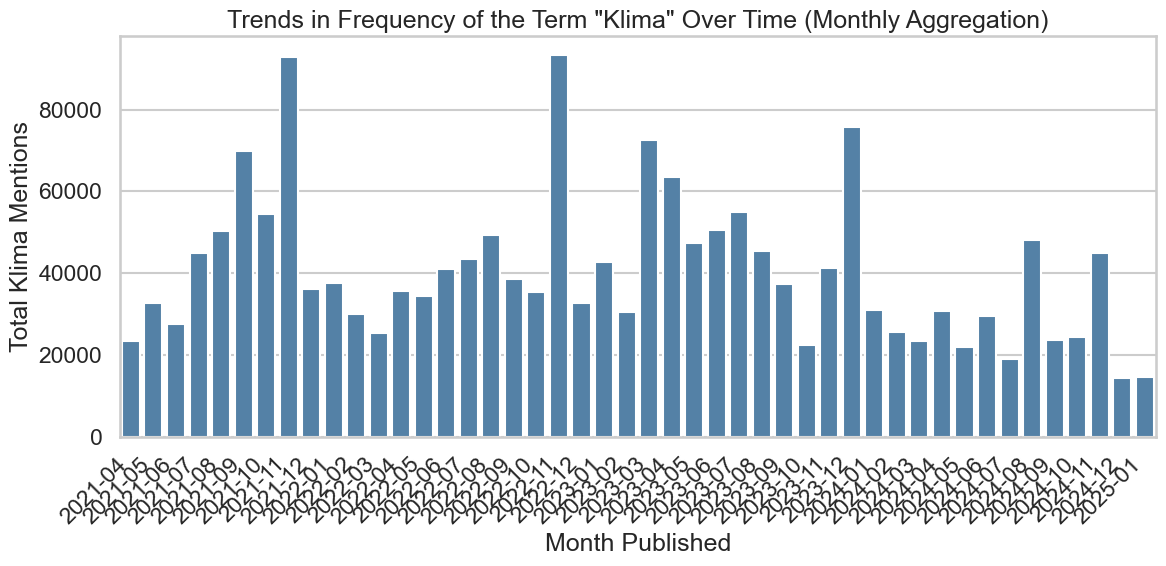

In [15]:
# Ensure 'data_published' is a datetime object
merged['data_published'] = pd.to_datetime(merged['data_published'])

# Aggregate by month, summing the 'klima_mentions_count'
monthly_trends = (
    merged.groupby(merged['data_published'].dt.to_period('M'))['klima_mentions_count']
    .sum()
    .reset_index()
)

# Convert period to string for plotting
monthly_trends['data_published'] = monthly_trends['data_published'].astype(str)

# Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='data_published', y='klima_mentions_count', data=monthly_trends, color='steelblue')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Month Published')
plt.ylabel('Total Klima Mentions')
plt.title('Trends in Frequency of the Term "Klima" Over Time (Monthly Aggregation)')

# Show the plot
plt.tight_layout()
plt.show()

2025-09-12 22:49:36,667 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-12 22:49:36,700 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


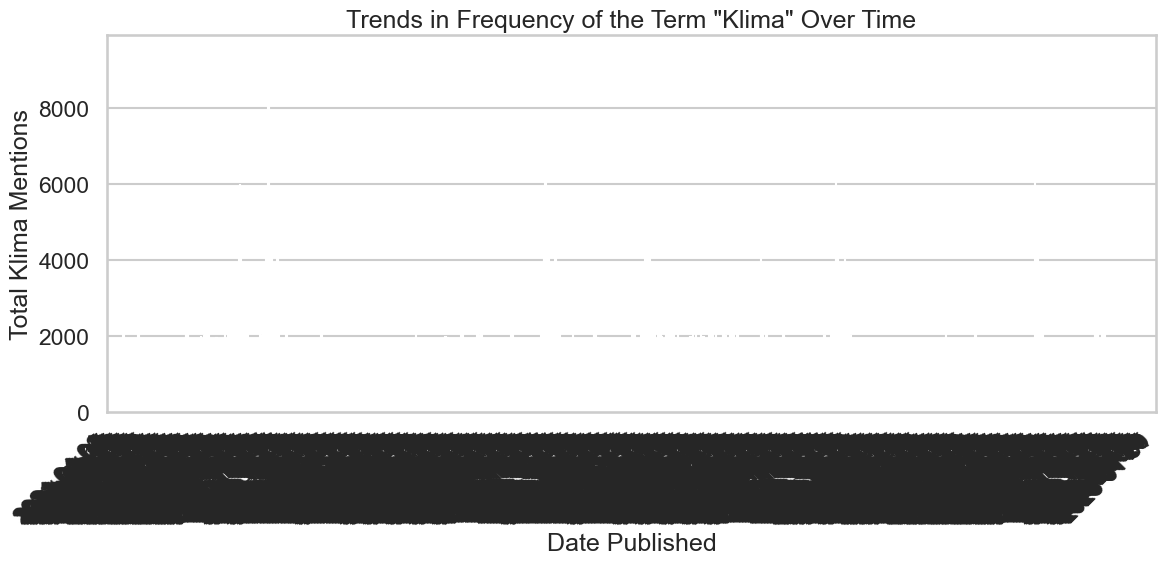

In [16]:
# Group by 'data_published' and sum the 'klima_mentions_count'
trends_in_frequency = merged.groupby('data_published')['klima_mentions_count'].sum().reset_index()

# Sort by 'data_published' to ensure dates are ordered correctly
trends_in_frequency_sorted = trends_in_frequency.sort_values('data_published')

# Plot the data with dates on the x-axis
plt.figure(figsize=(12, 6))
sns.barplot(x='data_published', y='klima_mentions_count', data=trends_in_frequency_sorted, color='steelblue')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Date Published')
plt.ylabel('Total Klima Mentions')
plt.title('Trends in Frequency of the Term "Klima" Over Time')

# Show the plot
plt.tight_layout()
plt.show()


2025-09-12 22:49:52,233 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-12 22:49:52,268 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


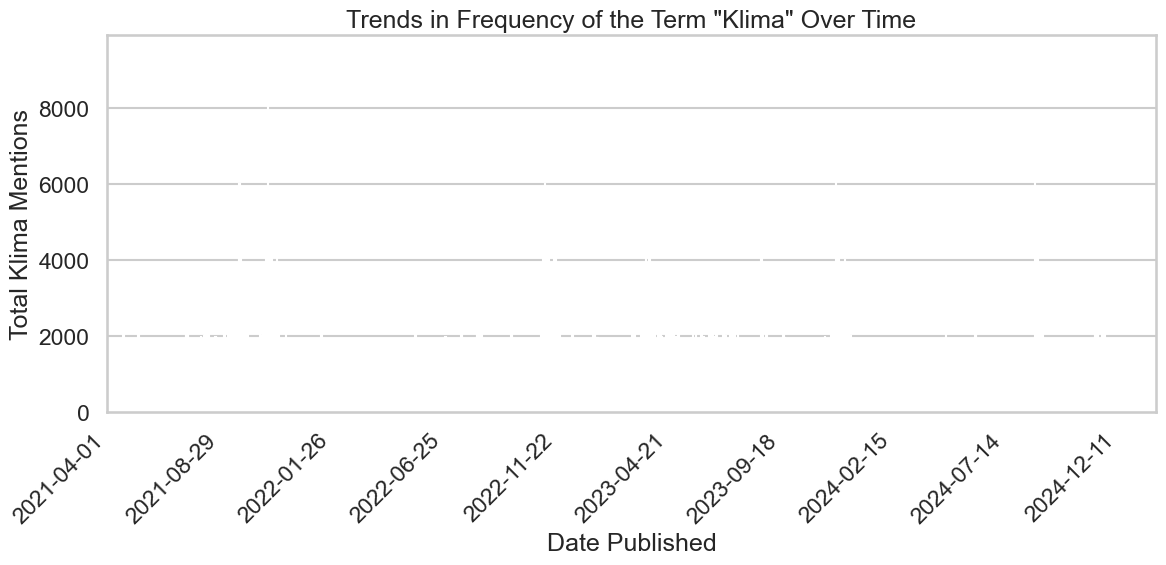

In [17]:
# Convert 'data_published' to datetime format
merged['data_published'] = pd.to_datetime(merged['data_published'])

# Create a complete date range from the min to max date in the data
date_range = pd.date_range(start=merged['data_published'].min(), end=merged['data_published'].max(), freq='D')

# Group by 'data_published' and sum the 'klima_mentions_count'
trends_in_frequency = merged.groupby('data_published')['klima_mentions_count'].sum().reset_index()

# Merge the trends with the complete date range, filling missing dates with 0
trends_in_frequency_full = pd.DataFrame(date_range, columns=['data_published'])
trends_in_frequency_full = trends_in_frequency_full.merge(trends_in_frequency, on='data_published', how='left')
trends_in_frequency_full['klima_mentions_count'] = trends_in_frequency_full['klima_mentions_count'].fillna(0)

# Plot the data with dates on the x-axis, treating them as a time series
plt.figure(figsize=(12, 6))
sns.barplot(x='data_published', y='klima_mentions_count', data=trends_in_frequency_full, color='steelblue')

# Format the x-axis to show dates correctly, adjusting tick spacing
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Add labels and title
plt.xlabel('Date Published')
plt.ylabel('Total Klima Mentions')
plt.title('Trends in Frequency of the Term "Klima" Over Time')

# Show the plot
plt.tight_layout()


2025-09-12 22:50:06,432 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-09-12 22:50:06,435 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


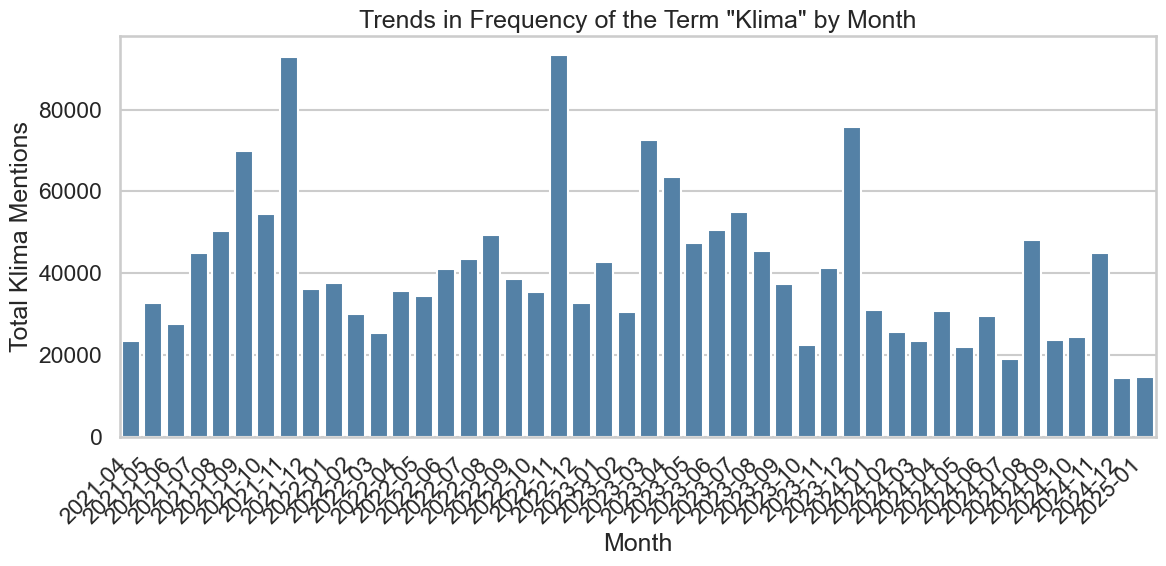

In [18]:
# Convert 'data_published' to datetime format
merged['data_published'] = pd.to_datetime(merged['data_published'])

# Create a complete date range from the min to max date in the data
date_range = pd.date_range(start=merged['data_published'].min(), end=merged['data_published'].max(), freq='D')

# Group by 'data_published' and sum the 'klima_mentions_count'
trends_in_frequency = merged.groupby('data_published')['klima_mentions_count'].sum().reset_index()

# Merge the trends with the complete date range, filling missing dates with 0
trends_in_frequency_full = pd.DataFrame(date_range, columns=['data_published'])
trends_in_frequency_full = trends_in_frequency_full.merge(trends_in_frequency, on='data_published', how='left')
trends_in_frequency_full['klima_mentions_count'] = trends_in_frequency_full['klima_mentions_count'].fillna(0)

# Extract month and year from 'data_published'
trends_in_frequency_full['month_year'] = trends_in_frequency_full['data_published'].dt.to_period('M')

# Group by 'month_year' and sum 'klima_mentions_count'
monthly_trends = trends_in_frequency_full.groupby('month_year')['klima_mentions_count'].sum().reset_index()

# Plot the data with months on the x-axis
plt.figure(figsize=(12, 6))
sns.barplot(x='month_year', y='klima_mentions_count', data=monthly_trends, color='steelblue')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Total Klima Mentions')
plt.title('Trends in Frequency of the Term "Klima" by Month')

# Show the plot
plt.tight_layout()
plt.show()


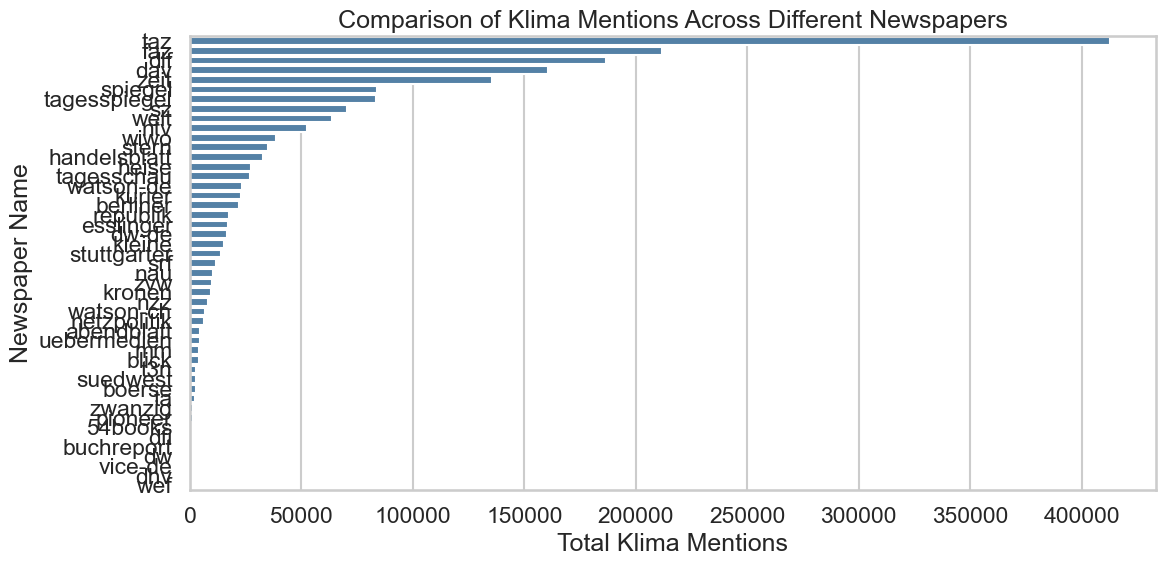

In [19]:
# Group by 'newspaper_name' and sum the 'klima_mentions_count'
media_comparison = merged.groupby('newspaper_name')['klima_mentions_count'].sum().reset_index()

# Sort by 'klima_mentions_count' to see the newspapers with the most mentions first
media_comparison_sorted = media_comparison.sort_values('klima_mentions_count', ascending=False)

# Plot the data using a horizontal bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='klima_mentions_count', y='newspaper_name', data=media_comparison_sorted, color='steelblue')

# Add labels and title
plt.xlabel('Total Klima Mentions')
plt.ylabel('Newspaper Name')
plt.title('Comparison of Klima Mentions Across Different Newspapers')

# Show the plot
plt.tight_layout()
plt.show()


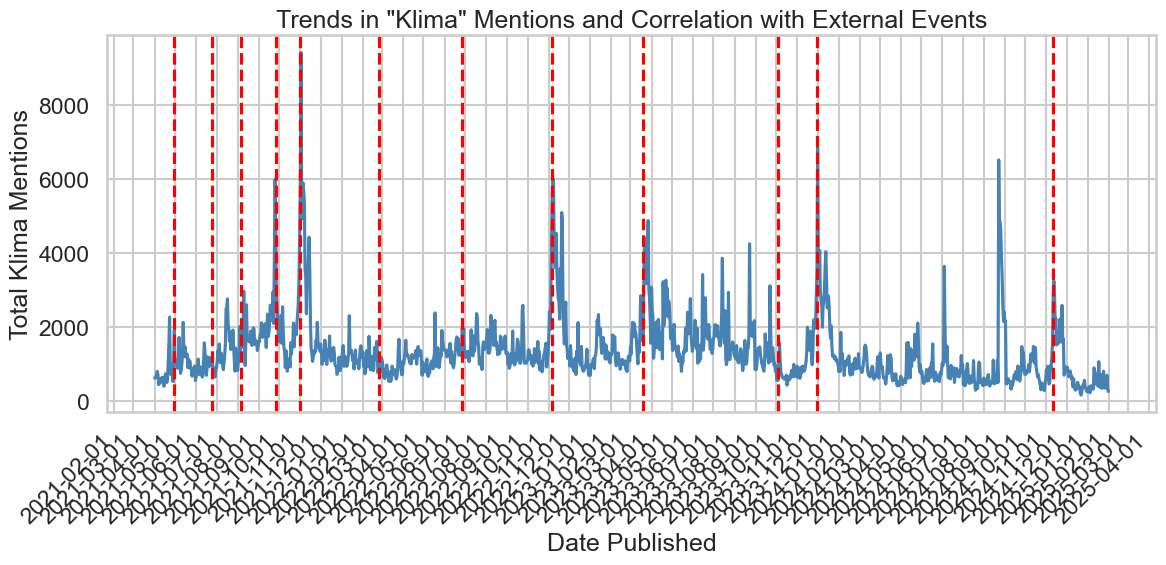

In [21]:
# Key external events (dates)

# Convert 'data_published' to datetime format
merged['data_published'] = pd.to_datetime(merged['data_published'])

# Group by 'data_published' and sum the 'klima_mentions_count'
trends_in_frequency = merged.groupby('data_published')['klima_mentions_count'].sum().reset_index()

# Plot the time series
plt.figure(figsize=(12, 6))
sns.lineplot(x='data_published', y='klima_mentions_count', data=trends_in_frequency, color='steelblue')

# Mark the external events with vertical lines
for event, date in events.items():
    plt.axvline(pd.to_datetime(date), linestyle='--', color='red', label=event)

# Formatting the plot
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Adjust date spacing
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

# Add labels, title, and legend
plt.xlabel('Date Published')
plt.ylabel('Total Klima Mentions')
plt.title('Trends in "Klima" Mentions and Correlation with External Events')
#plt.legend(title="Key Events")

# Show the plot
plt.tight_layout()
plt.show()


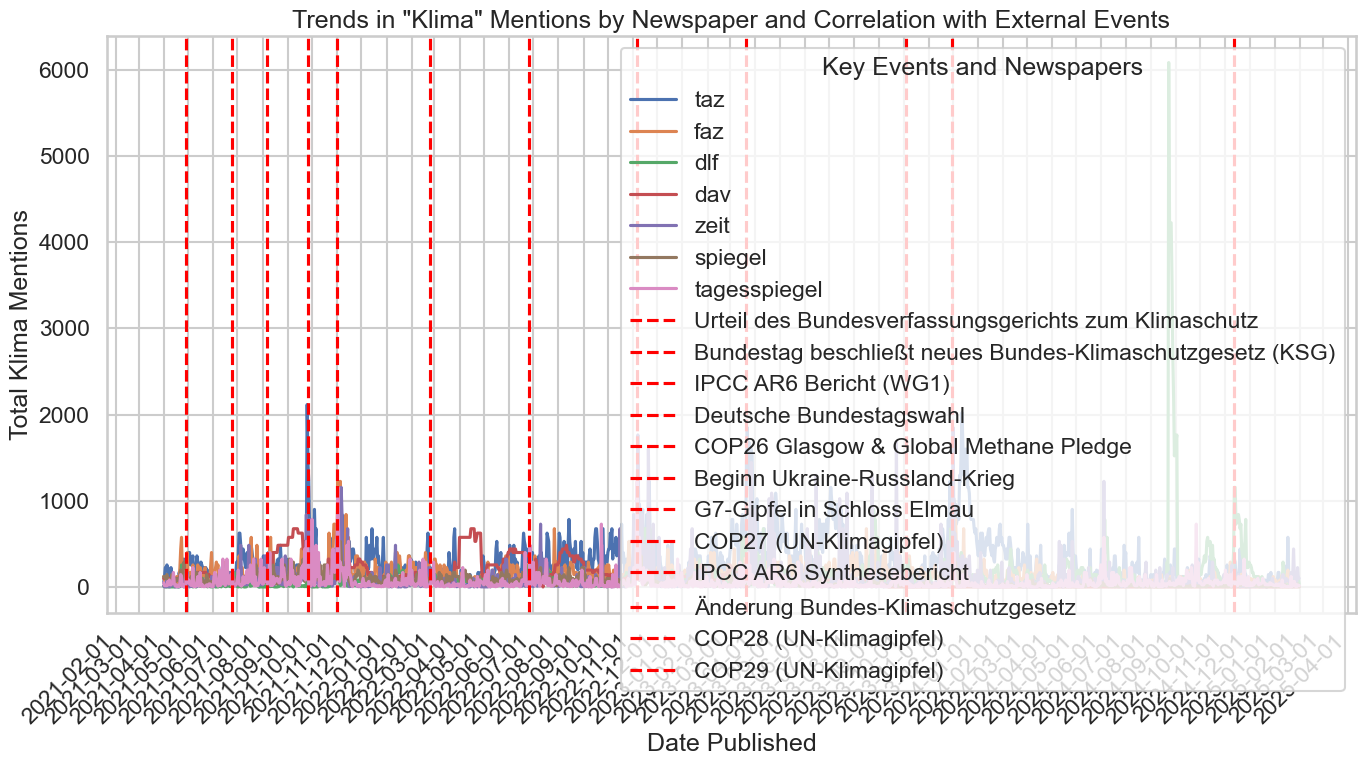

In [22]:
# Convert 'data_published' to datetime format
merged['data_published'] = pd.to_datetime(merged['data_published'])

# Sum 'klima_mentions_count' by newspaper
top_newspapers = merged.groupby('newspaper_name')['klima_mentions_count'].sum().nlargest(7).index

# Filter the data to include only the top 7 newspapers
top_newspapers_data = merged[merged['newspaper_name'].isin(top_newspapers)]

# Create a complete date range from the min to max date in the data
date_range = pd.date_range(start=top_newspapers_data['data_published'].min(), end=top_newspapers_data['data_published'].max(), freq='D')

# Plot for each top newspaper
plt.figure(figsize=(14, 8))
for newspaper in top_newspapers:
    newspaper_data = top_newspapers_data[top_newspapers_data['newspaper_name'] == newspaper]

    # Group by date and sum 'klima_mentions_count'
    trends_in_frequency = newspaper_data.groupby('data_published')['klima_mentions_count'].sum().reset_index()

    # Merge with the complete date range, filling missing dates with 0
    trends_in_frequency_full = pd.DataFrame(date_range, columns=['data_published'])
    trends_in_frequency_full = trends_in_frequency_full.merge(trends_in_frequency, on='data_published', how='left')
    trends_in_frequency_full['klima_mentions_count'] = trends_in_frequency_full['klima_mentions_count'].fillna(0)

    # Plot the time series line for the newspaper
    sns.lineplot(x='data_published', y='klima_mentions_count', data=trends_in_frequency_full, label=newspaper)

# Mark the external events with vertical lines
for event, date in events.items():
    plt.axvline(pd.to_datetime(date), linestyle='--', color='red', label=event)

# Formatting the plot
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Adjust date spacing
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

# Add labels, title, and legend
plt.xlabel('Date Published')
plt.ylabel('Total Klima Mentions')
plt.title('Trends in "Klima" Mentions by Newspaper and Correlation with External Events')
plt.legend(title="Key Events and Newspapers")

# Show the plot
plt.tight_layout()
plt.show()


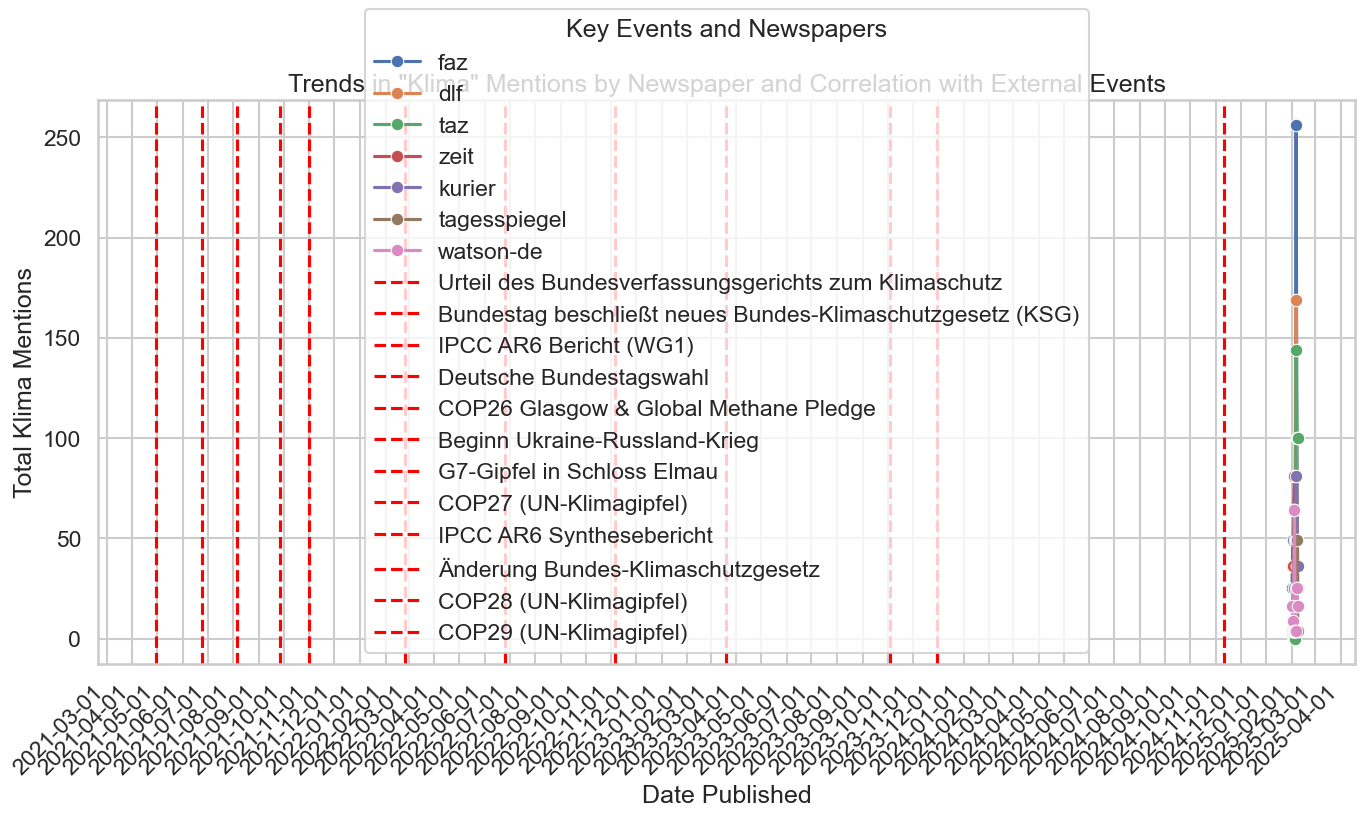

In [23]:
# Convert 'data_published' to datetime format
merged['data_published'] = pd.to_datetime(merged['data_published'])

# Sum 'klima_mentions_count' by newspaper
top_newspapers = merged.groupby('newspaper_name')['klima_mentions_count'].sum().nlargest(7).index

# Filter the data to include only the top 7 newspapers
top_newspapers_data = merged[merged['newspaper_name'].isin(top_newspapers)]

# Create a complete date range from the min to max date in the data
date_range = pd.date_range(start=top_newspapers_data['data_published'].min(), end=top_newspapers_data['data_published'].max(), freq='D')

# Plot for each top newspaper
plt.figure(figsize=(14, 8))
for newspaper in top_newspapers:
    newspaper_data = top_newspapers_data[top_newspapers_data['newspaper_name'] == newspaper]

    # Group by date and sum 'klima_mentions_count'
    trends_in_frequency = newspaper_data.groupby('data_published')['klima_mentions_count'].sum().reset_index()

    # Merge with the complete date range, filling missing dates with 0
    trends_in_frequency_full = pd.DataFrame(date_range, columns=['data_published'])
    trends_in_frequency_full = trends_in_frequency_full.merge(trends_in_frequency, on='data_published', how='left')
    trends_in_frequency_full['klima_mentions_count'] = trends_in_frequency_full['klima_mentions_count'].fillna(0)

    # Plot the time series line for the newspaper
    sns.lineplot(x='data_published', y='klima_mentions_count', data=trends_in_frequency_full, label=newspaper, markers=True, marker='o')

# Mark the external events with vertical lines
for event, date in events.items():
    plt.axvline(pd.to_datetime(date), linestyle='--', color='red', label=event)

# Formatting the plot
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Adjust date spacing
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

# Add labels, title, and legend
plt.xlabel('Date Published')
plt.ylabel('Total Klima Mentions')
plt.title('Trends in "Klima" Mentions by Newspaper and Correlation with External Events')
plt.legend(title="Key Events and Newspapers")

# Show the plot
plt.tight_layout()
plt.show()


sentiment analyese

<Figure size 1400x800 with 0 Axes>

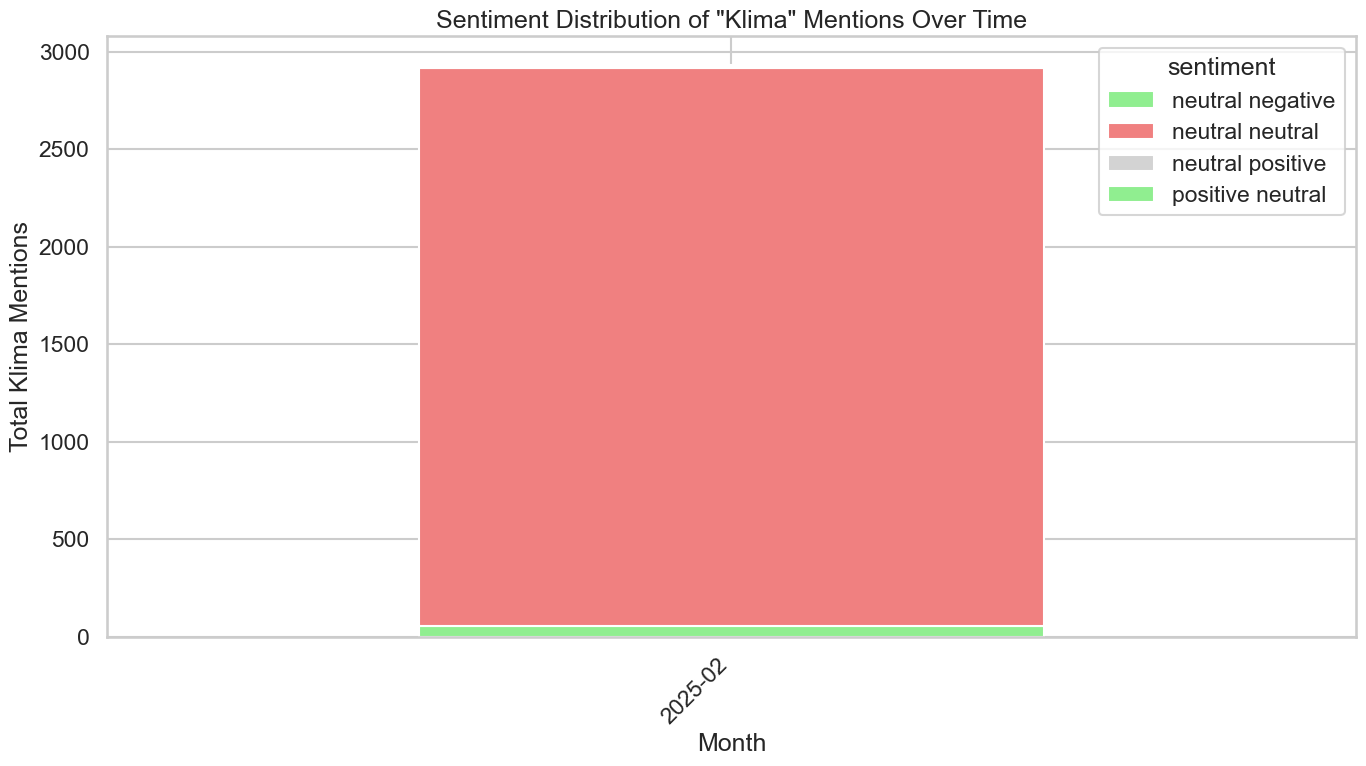

In [24]:
from textblob import TextBlob

# Perform sentiment analysis on the 'pre_context' and 'post_context' columns
def get_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to both 'pre_context' and 'post_context'
merged['sentiment_pre'] = merged['pre_context'].apply(get_sentiment)
merged['sentiment_post'] = merged['post_context'].apply(get_sentiment)

# Combine both sentiments into a single column
merged['sentiment'] = merged['sentiment_pre'] + ' ' + merged['sentiment_post']

# Convert 'data_published' to datetime format
merged['data_published'] = pd.to_datetime(merged['data_published'])

# Create a date range (monthly, for example)
merged['month_year'] = merged['data_published'].dt.to_period('M')

# Count the frequency of sentiments and sum 'klima_mentions_count' for each period
sentiment_data = merged.groupby(['month_year', 'sentiment'])['klima_mentions_count'].sum().reset_index()

# Pivot the data to get separate columns for each sentiment type (positive, negative, neutral)
sentiment_pivot = sentiment_data.pivot_table(index='month_year', columns='sentiment', values='klima_mentions_count', aggfunc='sum').fillna(0)

# Plot the sentiment distribution over time (stacked bar plot)
plt.figure(figsize=(14, 8))
sentiment_pivot.plot(kind='bar', stacked=True, figsize=(14, 8), color=['lightgreen', 'lightcoral', 'lightgrey'])

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Total Klima Mentions')
plt.title('Sentiment Distribution of "Klima" Mentions Over Time')
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Group by 'suffix' and count occurrences
suffix_counts = merged['suffix'].value_counts().head(7).index

# Filter the data to include only the top 7 suffixes
top_suffix_data = merged[merged['suffix'].isin(suffix_counts)]

# Convert 'data_published' to datetime format
top_suffix_data['data_published'] = pd.to_datetime(top_suffix_data['data_published'])

# Create a complete date range from the min to max date in the data
date_range = pd.date_range(start=top_suffix_data['data_published'].min(), end=top_suffix_data['data_published'].max(), freq='M')

# Plot for each of the top 7 suffixes
plt.figure(figsize=(14, 8))
for suffix in suffix_counts:
    # Filter the data for the current suffix
    suffix_data = top_suffix_data[top_suffix_data['suffix'] == suffix]

    # Group by date and count the occurrences of the suffix
    suffix_trends = suffix_data.groupby('data_published').size().reset_index(name='count')

    # Merge with the complete date range, filling missing dates with 0
    suffix_trends_full = pd.DataFrame(date_range, columns=['data_published'])
    suffix_trends_full = suffix_trends_full.merge(suffix_trends, on='data_published', how='left')
    suffix_trends_full['count'] = suffix_trends_full['count'].fillna(0)

    # Plot the time series line for the suffix
    sns.lineplot(x='data_published', y='count', data=suffix_trends_full, label=suffix)

# Formatting the plot
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date Published')
plt.ylabel('Frequency of Suffix')
plt.title('Trends of the Top 7 Suffix Words Over Time')

# Show the plot
plt.tight_layout()
plt.legend(title="Suffix Words")
plt.show()


/var/folders/00/zvrzzhp93b77bpbrw_0v2lcm0000gn/T/ipykernel_31870/844736704.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_suffix_data['data_published'] = pd.to_datetime(top_suffix_data['data_published'])


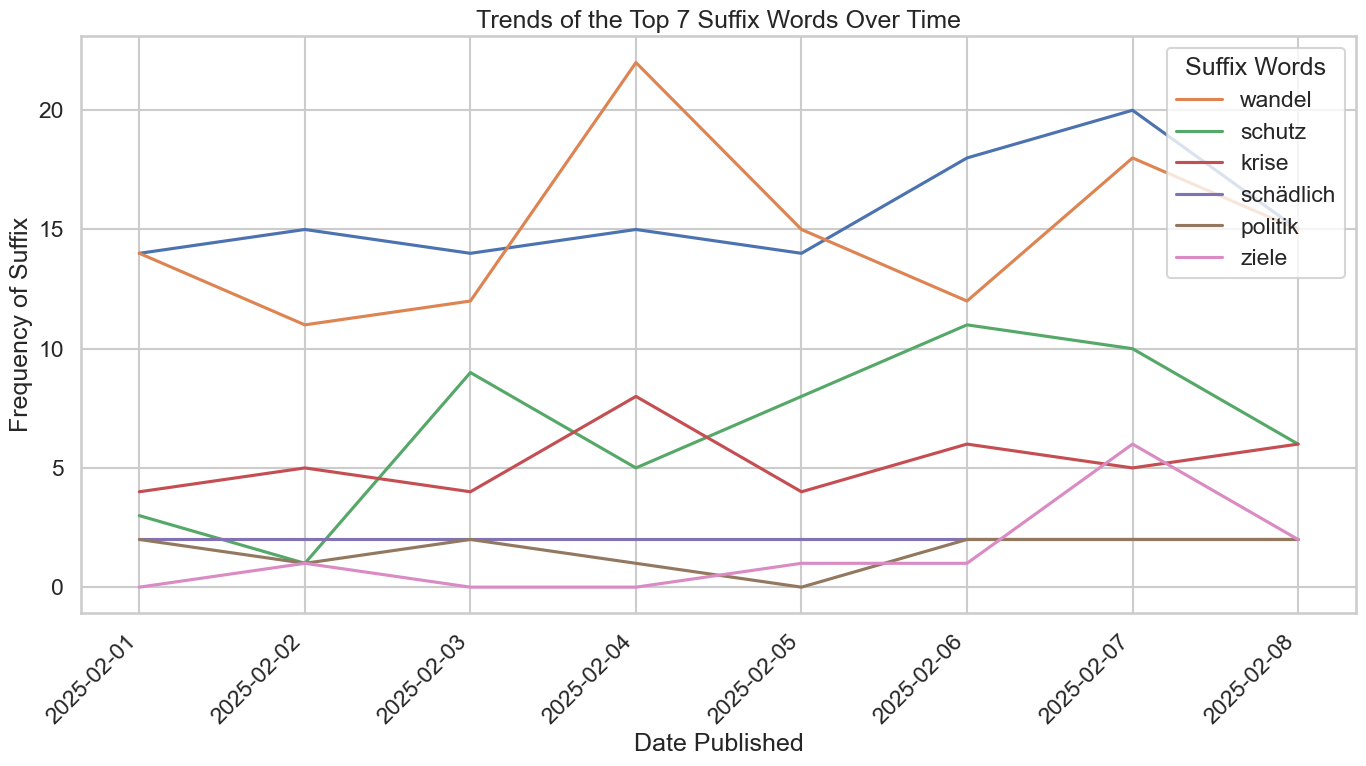

In [25]:
# Group by 'suffix' and count occurrences
suffix_counts = merged['suffix'].value_counts().head(7).index

# Filter the data to include only the top 7 suffixes
top_suffix_data = merged[merged['suffix'].isin(suffix_counts)]

# Convert 'data_published' to datetime format
top_suffix_data['data_published'] = pd.to_datetime(top_suffix_data['data_published'])

# Create a complete date range from the min to max date in the data
date_range = pd.date_range(start=top_suffix_data['data_published'].min(), end=top_suffix_data['data_published'].max(), freq='D')

# Plot for each of the top 7 suffixes
plt.figure(figsize=(14, 8))
for suffix in suffix_counts:
    # Filter the data for the current suffix
    suffix_data = top_suffix_data[top_suffix_data['suffix'] == suffix]

    # Group by date and count the occurrences of the suffix
    suffix_trends = suffix_data.groupby('data_published').size().reset_index(name='count')

    # Merge with the complete date range, filling missing dates with 0
    suffix_trends_full = pd.DataFrame(date_range, columns=['data_published'])
    suffix_trends_full = suffix_trends_full.merge(suffix_trends, on='data_published', how='left')
    suffix_trends_full['count'] = suffix_trends_full['count'].fillna(0)

    # Plot the time series line for the suffix
    sns.lineplot(x='data_published', y='count', data=suffix_trends_full, label=suffix)

# Formatting the plot
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date Published')
plt.ylabel('Frequency of Suffix')
plt.title('Trends of the Top 7 Suffix Words Over Time')

# Show the plot
plt.tight_layout()
plt.legend(title="Suffix Words")
plt.show()


In [26]:
from fuzzywuzzy import fuzz, process

/Users/edwinw/Documents/DBU Uni/wortwandel/.venv/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [27]:
# Extract all unique suffixes
# and Convert suffixes to lowercase before
merged['suffix'] = merged['suffix'].str.lower()
unique_suffixes = merged['suffix'].unique()
print(unique_suffixes)

<StringArray>
[          'wandel',       'aktivistin',     'freundlicher',
            'krise',                 '',           'schutz',
            'wende',          'risiken',           'häuser',
          'politik',          'wandels',           'anlage',
        'schädlich',          'debatte',         'abkommen',
   'schutzabkommen',             'fest',           'fragen',
          'allianz',           'seiten',       'profiteure',
            'ziele',             'blog',           'killer',
       'flüchtling',       'aktivisten',            'labor',
       'freundlich',         'stadtrat',      'ministerium',
         'stiftung',      'neutralität',            'küche',
         'prognose',           'sünden',       'zerstörung',
           'zielen',                's',          'neutral',
        'neutralen',     'freundlichen',           'bilanz',
           'sünder',            'szene',         'aktivist',
             'ziel',            'daten',         'kabinett',
         '

In [28]:
# Step 2: Group similar words using fuzzy matching
def group_similar_words(suffixes, threshold=80):
    groups = []
    mapped = set()  # To keep track of words that have already been mapped
    grouped_words = {}  # This will hold the final group mapping

    while suffixes:
        word = suffixes.pop(0)
        if word in mapped:
            continue  # Skip if the word is already processed

        group = [word]
        mapped.add(word)  # Mark the word as processed
        for other_word in suffixes[:]:
            if fuzz.ratio(word, other_word) > threshold:
                group.append(other_word)
                mapped.add(other_word)
                suffixes.remove(other_word)
        groups.append(group)

    # Creating a dictionary to map similar words to the root form
    for group in groups:
        root_word = group[0]  # Take the first word as the root
        for word in group:
            grouped_words[word] = root_word

    return grouped_words

In [29]:
# Apply the function to group the suffixes
unique_suffixes = merged['suffix'].unique().tolist()
unique_suffixes

['wandel',
 'aktivistin',
 'freundlicher',
 'krise',
 '',
 'schutz',
 'wende',
 'risiken',
 'häuser',
 'politik',
 'wandels',
 'anlage',
 'schädlich',
 'debatte',
 'abkommen',
 'schutzabkommen',
 'fest',
 'fragen',
 'allianz',
 'seiten',
 'profiteure',
 'ziele',
 'blog',
 'killer',
 'flüchtling',
 'aktivisten',
 'labor',
 'freundlich',
 'stadtrat',
 'ministerium',
 'stiftung',
 'neutralität',
 'küche',
 'prognose',
 'sünden',
 'zerstörung',
 'zielen',
 's',
 'neutral',
 'neutralen',
 'freundlichen',
 'bilanz',
 'sünder',
 'szene',
 'aktivist',
 'ziel',
 'daten',
 'kabinett',
 'forscher',
 'phänomen',
 'radikale',
 'kunst',
 'bericht',
 'sozialpolitik',
 'gruppe',
 'fakten',
 'vorgaben',
 'freundliche',
 'wissenschaftler',
 'bonus',
 'schutzministerin',
 'wandeldienst',
 'schutzgesetz',
 'pläne',
 'schutzpläne',
 'kleber',
 'experten',
 'dienst',
 'schützer',
 'sichere',
 'plan']

In [30]:
# Apply the function to group the suffixes
grouped_words = group_similar_words(unique_suffixes)
grouped_words

{'wandel': 'wandel',
 'wandels': 'wandel',
 'aktivistin': 'aktivistin',
 'aktivisten': 'aktivistin',
 'aktivist': 'aktivistin',
 'freundlicher': 'freundlicher',
 'freundlich': 'freundlicher',
 'freundlichen': 'freundlicher',
 'freundliche': 'freundlicher',
 'krise': 'krise',
 '': '',
 'schutz': 'schutz',
 'wende': 'wende',
 'risiken': 'risiken',
 'häuser': 'häuser',
 'politik': 'politik',
 'anlage': 'anlage',
 'schädlich': 'schädlich',
 'debatte': 'debatte',
 'abkommen': 'abkommen',
 'schutzabkommen': 'schutzabkommen',
 'fest': 'fest',
 'fragen': 'fragen',
 'allianz': 'allianz',
 'seiten': 'seiten',
 'profiteure': 'profiteure',
 'ziele': 'ziele',
 'zielen': 'ziele',
 'ziel': 'ziele',
 'blog': 'blog',
 'killer': 'killer',
 'flüchtling': 'flüchtling',
 'labor': 'labor',
 'stadtrat': 'stadtrat',
 'ministerium': 'ministerium',
 'stiftung': 'stiftung',
 'neutralität': 'neutralität',
 'küche': 'küche',
 'prognose': 'prognose',
 'sünden': 'sünden',
 'sünder': 'sünden',
 'zerstörung': 'zerstör

In [31]:
# Step 3: Replace suffixes in the dataset with their corresponding root word
merged['grouped_suffix'] = merged['suffix'].map(grouped_words).fillna(merged['suffix'])

In [32]:
# Check the replacement mapping
print("Suffix mapping:")
print(merged[['suffix', 'grouped_suffix']])

Suffix mapping:
           suffix grouped_suffix
0          wandel         wandel
1          wandel         wandel
2      aktivistin     aktivistin
3      aktivistin     aktivistin
4    freundlicher   freundlicher
..            ...            ...
572                             
573                             
574                             
575                             
576                             

[577 rows x 2 columns]


In [33]:
# Step 4: Group by 'grouped_suffix' and 'data_published', sum the counts
aggregated_data = merged.groupby(['data_published', 'grouped_suffix'])['klima_mentions_count'].sum().reset_index()
aggregated_data

,data_published,grouped_suffix,klima_mentions_count
0,2025-02-01,,44
1,2025-02-01,abkommen,6
2,2025-02-01,aktivistin,14
3,2025-02-01,allianz,1
4,2025-02-01,anlage,1
...,...,...,...
170,2025-02-08,schützer,3
171,2025-02-08,seiten,6
172,2025-02-08,sichere,10
173,2025-02-08,wandel,82


In [34]:
# Step 5: Get the top 14 most common grouped suffixes
top_suffixes = aggregated_data[aggregated_data['grouped_suffix'] != ''] \
    .groupby('grouped_suffix')['klima_mentions_count'].sum().nlargest(14).index
top_suffixes

Index(['wandel', 'schutz', 'krise', 'ziele', 'aktivistin', 'fragen',
       'abkommen', 'politik', 'freundlicher', 'schutzabkommen', 'wende',
       'bonus', 'bilanz', 'seiten'],
      dtype='object', name='grouped_suffix')

In [35]:
# Step 6: Filter the data to include only the top 14 suffixes
filtered_data = aggregated_data[aggregated_data['grouped_suffix'].isin(top_suffixes)]
filtered_data

,data_published,grouped_suffix,klima_mentions_count
1,2025-02-01,abkommen,6
2,2025-02-01,aktivistin,14
7,2025-02-01,fragen,1
8,2025-02-01,freundlicher,6
10,2025-02-01,krise,11
...,...,...,...
167,2025-02-08,politik,8
168,2025-02-08,schutz,43
171,2025-02-08,seiten,6
173,2025-02-08,wandel,82


In [36]:
# Ensure data_published is treated as a datetime object
filtered_data.loc[:, 'data_published'] = pd.to_datetime(filtered_data['data_published'])

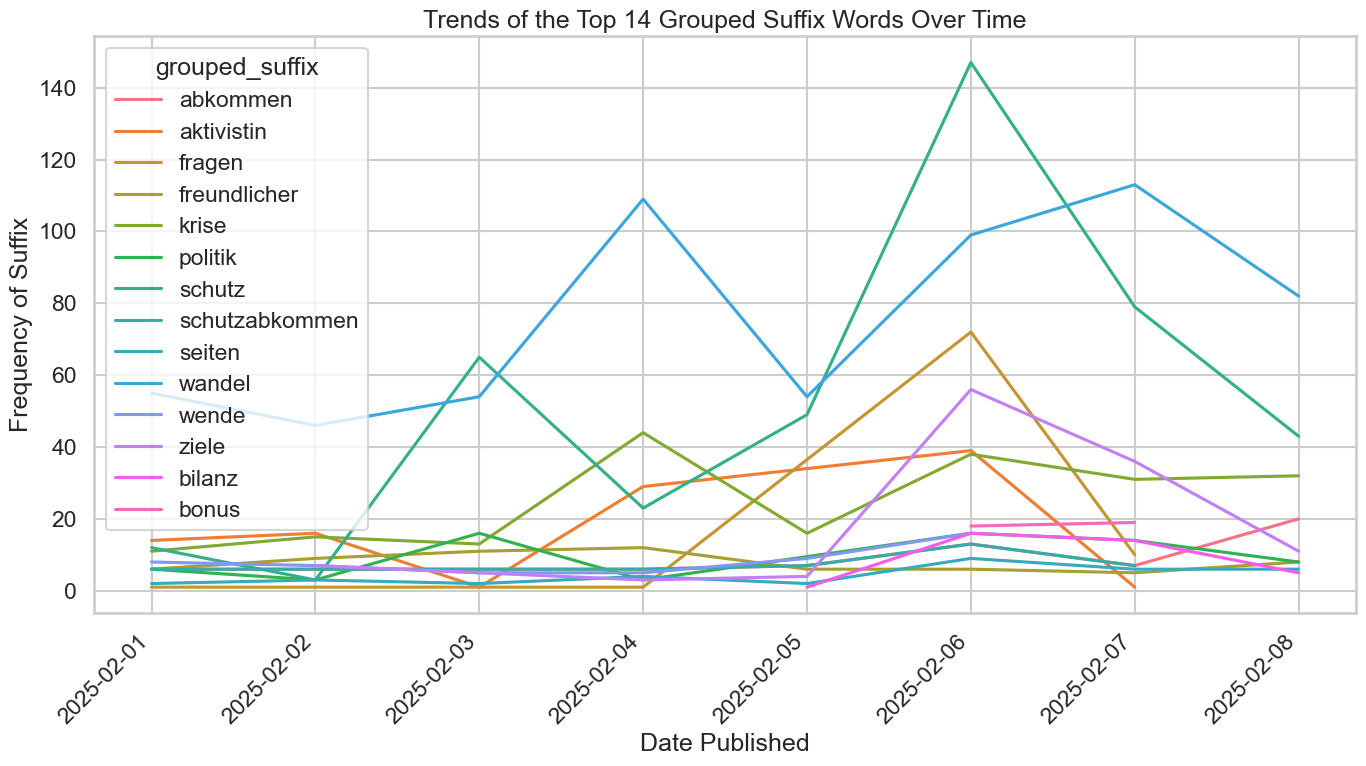

In [37]:
# Plotting the trends of the top 14 suffixes
plt.figure(figsize=(14, 8))
sns.lineplot(data=filtered_data, x='data_published', y='klima_mentions_count', hue='grouped_suffix')

# Formatting the plot
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date Published')
plt.ylabel('Frequency of Suffix')
plt.title('Trends of the Top 14 Grouped Suffix Words Over Time')

# Show the plot
plt.tight_layout()
plt.show()

In [38]:
Wörter im namen mit top suffix

SyntaxError: invalid syntax (2634889389.py, line 1)